In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DIC_assignment_1')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/DIC_assignment_1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# **Part 1**
### **Task1:  Data Cleaning and Exploration**

In [ ]:
def load_and_normalize_data(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

    print("Normalizing date column format...")
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')

    if df['Date'].isnull().sum() > 0:
        print(f"Warning: {df['Date'].isnull().sum()} dates could not be parsed and were converted to NaT.")
        df.dropna(subset=['Date'], inplace=True)
        print("Rows with unparsable dates have been dropped.")

    df.sort_values(by='Date', inplace=True)

    return df

file_name = 'sp_500.csv'
df_normalized = load_and_normalize_data(file_name)

if df_normalized is not None:
    print("\nDataFrame with normalized Date column:")
    print(df_normalized.head())

Normalizing date column format...

DataFrame with normalized Date column:
           Date  SP500  Dividend  Earnings  Consumer Price Index  \
1832 1871-01-01   4.59      0.26       0.4                 12.37   
1831 1871-01-01   4.44      0.26       0.4                 12.46   
1830 1871-02-01   4.50      0.26       0.4                 12.84   
1829 1871-03-01   4.61      0.26       0.4                 13.03   
1828 1871-04-01   4.74      0.26       0.4                 12.56   

      Long Interest Rate  Real Price  Real Dividend  Real Earnings  PE10  
1832                5.35      113.60           6.43           9.90   0.0  
1831                5.32      109.05           6.39           9.82   0.0  
1830                5.32      107.25           6.20           9.53   0.0  
1829                5.33      108.27           6.11           9.39   0.0  
1828                5.33      115.54           6.34           9.75   0.0  


/tmp/ipython-input-3846966564.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')


In [ ]:
# meta data of df from csv
print("Dimension of the data frame: ", df_normalized.shape)
df_normalized.info()

Dimension of the data frame:  (1833, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 1833 entries, 1832 to 0
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1833 non-null   datetime64[ns]
 1   SP500                 1833 non-null   float64       
 2   Dividend              1833 non-null   float64       
 3   Earnings              1833 non-null   float64       
 4   Consumer Price Index  1833 non-null   float64       
 5   Long Interest Rate    1833 non-null   float64       
 6   Real Price            1833 non-null   float64       
 7   Real Dividend         1833 non-null   float64       
 8   Real Earnings         1833 non-null   float64       
 9   PE10                  1833 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 157.5 KB


In [ ]:
duplicate_rows = df_normalized.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

Number of duplicate rows: 0


In [ ]:
duplicate_dates = df_normalized[df_normalized.duplicated(subset=['Date'], keep=False)]

# Check for duplicates
if len(duplicate_dates) > 0:
    print(f"Total records with duplicate dates: {len(duplicate_dates)}")
    print(f"Number of unique dates that have duplicates: {duplicate_dates['Date'].nunique()}")

    # Sort by Date
    duplicate_dates_sorted = duplicate_dates.sort_values(by='Date')

    print("\nAll duplicate records sorted by date:")
    print(duplicate_dates_sorted)

    print("\n" + "="*50)
    print("DETAILED VIEW BY DUPLICATE DATE:")
    print("="*50)

    # Group by date
    duplicate_stats = duplicate_dates.groupby('Date').size().reset_index(name='count')
    duplicate_stats = duplicate_stats.sort_values(by='count', ascending=False)

    print("\nDuplicate date statistics:")
    print(duplicate_stats)

    # top 10 dates with most duplicates
    print(f"\nTop 10 dates with most duplicates:")
    for i, (date, count) in enumerate(duplicate_stats.head(10).values):
        print(f"{i+1}. {date}: {count} duplicates")

    print(f"\nSample of duplicate entries:")
    sample_dates = duplicate_stats.head(3)['Date'].tolist()
    for date in sample_dates:
        date_entries = duplicate_dates[duplicate_dates['Date'] == date]
        print(f"\nDate: {date}")
        print(date_entries)
        print("-" * 50)

else:
    print("No duplicate dates found in the dataset.")

Total records with duplicate dates: 304
Number of unique dates that have duplicates: 152

All duplicate records sorted by date:
           Date        SP500  Dividend    Earnings  Consumer Price Index  \
1832 1871-01-01     4.590000      0.26    0.400000                 12.37   
1831 1871-01-01     4.440000      0.26    0.400000                 12.46   
1819 1872-01-01     4.860000      0.26    0.402500                 12.65   
1820 1872-01-01     4.970000      0.29    0.425000                 12.75   
1807 1873-01-01     5.110000      0.30    0.432500                 12.94   
...         ...          ...       ...         ...                   ...   
43   2020-01-01  3278.202857     58.69  131.756667                257.97   
32   2021-01-01  4460.707143     59.64  182.910000                276.59   
31   2021-01-01  3793.748421     58.06  105.486667                261.58   
20   2022-01-01  3726.050952     65.85  182.403333                298.01   
19   2022-01-01  4573.815500     60.

In [ ]:
# Get all numerical columns
numerical_columns = df_normalized.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns to analyze:", numerical_columns)

# Analyze ALL numerical columns for duplicates
duplicate_stats = duplicate_dates.groupby('Date').agg({
    col: ['count', 'std', 'mean', 'min', 'max']
    for col in numerical_columns
}).round(2)

print("Complete statistical analysis of duplicate dates:")
print(duplicate_stats.head(10))

print("\nAverage statistics across all duplicate dates:")
avg_stats = duplicate_stats.mean()
print(avg_stats)

Numerical columns to analyze: ['SP500', 'Dividend', 'Earnings', 'Consumer Price Index', 'Long Interest Rate', 'Real Price', 'Real Dividend', 'Real Earnings', 'PE10']
Complete statistical analysis of duplicate dates:
           SP500                         Dividend                          \
           count   std  mean   min   max    count   std  mean   min   max   
Date                                                                        
1871-01-01     2  0.11  4.52  4.44  4.59        2  0.00  0.26  0.26  0.26   
1872-01-01     2  0.08  4.92  4.86  4.97        2  0.02  0.28  0.26  0.29   
1873-01-01     2  0.65  4.65  4.19  5.11        2  0.01  0.31  0.30  0.32   
1874-01-01     2  0.09  4.60  4.53  4.66        2  0.00  0.33  0.33  0.33   
1875-01-01     2  0.17  4.42  4.30  4.54        2  0.02  0.32  0.30  0.33   
1876-01-01     2  0.56  4.06  3.67  4.46        2  0.00  0.30  0.30  0.30   
1877-01-01     2  0.17  3.43  3.31  3.55        2  0.06  0.25  0.21  0.29   
1878-01-01    

**All duplicates have exactly 2 entries**

Significant variations exist in many columns:
*   SP500: Average std=27.44 (quite high)
*   Real Price: Average std=55.23 (very high)
*   Real Earnings: Average std=3.88 (moderate)
*   PE10: Average std=1.50 (moderate)

Some columns are very consistent:
*   Dividend: Average std=0.295
*   Consumer Price Index: Average std=1.33

**Strategy for handling duplications is Weighted mean**

In [ ]:
def handle_duplicates_weighted_mean(group):
    if len(group) == 1:
        return group
    else:
        mean_values = group.mean(numeric_only=True)
        mean_values['Date'] = group['Date'].iloc[0]
        return mean_values.to_frame().T

df_cleaned = df_normalized.groupby('Date', as_index=False).apply(handle_duplicates_weighted_mean).reset_index(drop=True)

print(f"Dataset shape before: {df_normalized.shape}")
print(f"Dataset shape after: {df_cleaned.shape}")

Dataset shape before: (1833, 10)
Dataset shape after: (1681, 10)


/tmp/ipython-input-2510747438.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_normalized.groupby('Date', as_index=False).apply(handle_duplicates_weighted_mean).reset_index(drop=True)


In [ ]:
df_cleaned[df_cleaned.duplicated(subset=['Date'], keep=False)]

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date


In [ ]:
print("Calculating percentage of missing values per column...")
missing_percentage = df_cleaned.isnull().sum() / len(df_cleaned) * 100
print("Percentage of missing values per column:")
print(missing_percentage)


Calculating percentage of missing values per column...
Percentage of missing values per column:
SP500                   0.0
Dividend                0.0
Earnings                0.0
Consumer Price Index    0.0
Long Interest Rate      0.0
Real Price              0.0
Real Dividend           0.0
Real Earnings           0.0
PE10                    0.0
Date                    0.0
dtype: float64


There are no missing values in the dataset, hence skipping the imputation part

In [ ]:
df_converted = df_cleaned.apply(pd.to_numeric, errors='ignore')

if 'Date' in df_converted.columns and df_converted['Date'].dtype == 'object':
    df_converted['Date'] = pd.to_datetime(df_converted['Date'], errors='coerce')

print(df_converted.dtypes)

SP500                          float64
Dividend                       float64
Earnings                       float64
Consumer Price Index           float64
Long Interest Rate             float64
Real Price                     float64
Real Dividend                  float64
Real Earnings                  float64
PE10                           float64
Date                    datetime64[ns]
dtype: object


/tmp/ipython-input-935135789.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_converted = df_cleaned.apply(pd.to_numeric, errors='ignore')


In [ ]:
df_cleaned = df_converted

In [ ]:
print(df_cleaned.dtypes)

SP500                          float64
Dividend                       float64
Earnings                       float64
Consumer Price Index           float64
Long Interest Rate             float64
Real Price                     float64
Real Dividend                  float64
Real Earnings                  float64
PE10                           float64
Date                    datetime64[ns]
dtype: object


In [ ]:
numeric_df = df_cleaned.select_dtypes(include='number')

summary_stats = numeric_df.describe()
summary_stats.rename(index={'50%': 'median'}, inplace=True)
reordered_stats = summary_stats.loc[['min', 'max', 'mean', 'median', 'std']]

print(reordered_stats)

              SP500   Dividend    Earnings  Consumer Price Index  \
min        2.730000   0.000000    0.000000              6.280000   
max     4674.772727  68.710000  197.910000            306.130000   
mean     379.037867   7.489703   17.608274             65.454149   
median    18.250000   0.910000    1.513330             22.000000   
std      812.522395  13.681302   34.658626             80.308099   

        Long Interest Rate   Real Price  Real Dividend  Real Earnings  \
min               0.620000    82.870000       0.000000       0.000000   
max              15.320000  5140.590000      71.220000     217.260000   
mean              4.488316   745.776544      20.227617      41.148980   
median            3.800000   324.810000      16.220000      26.790000   
std               2.296612   918.398789      13.551489      37.700639   

             PE10  
min      0.000000  
max     48.110000  
mean    19.472719  
median  19.810000  
std      8.802615  


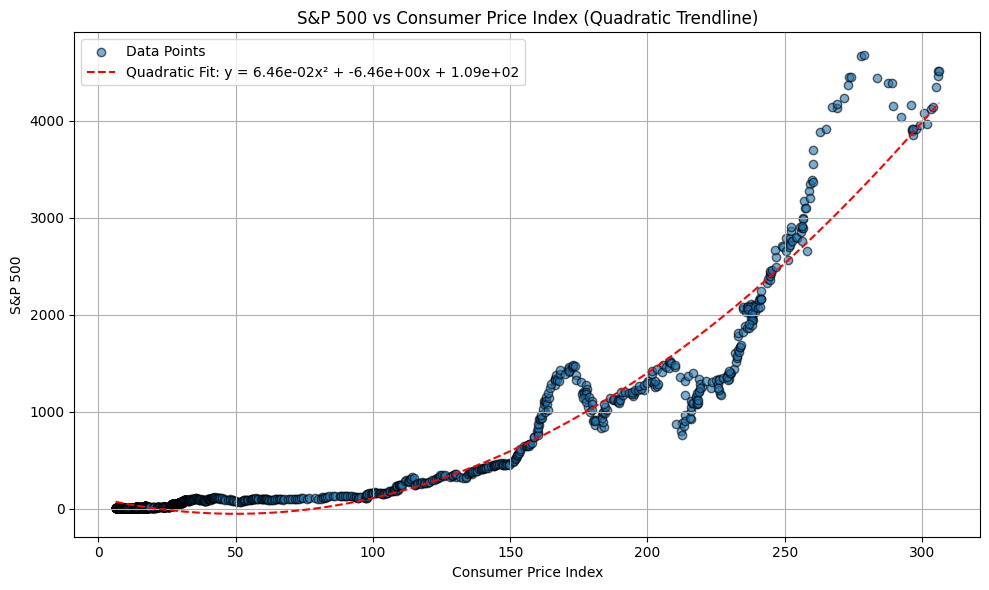

In [ ]:
df_plot = df_cleaned.dropna(subset=['SP500', 'Consumer Price Index'])

x = df_plot['Consumer Price Index'].values
y = df_plot['SP500'].values

# Fit a 2nd-degree polynomial
coeffs = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs)

x_line = np.linspace(min(x), max(x), 500)
y_quad = poly(x_line)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, edgecolor='k', label='Data Points')
plt.plot(x_line, y_quad, 'r--', label=f'Quadratic Fit: y = {coeffs[0]:.2e}x² + {coeffs[1]:.2e}x + {coeffs[2]:.2e}')

plt.title('S&P 500 vs Consumer Price Index (Quadratic Trendline)')
plt.xlabel('Consumer Price Index')
plt.ylabel('S&P 500')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Scatter plot is the best way to visualize two correlated variables. Here it is clearly visible that S&P 500 and CPI are exponentially related hence a quadratic line is suitable to depict an ovdrall trend. Going forward linear regression won't be a good performing model on this data

### **Task 2:  Feature Engineering**

In [ ]:
df_cleaned.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date
0,4.515,0.26,0.4,12.415,5.335,111.325,6.41,9.86,0.0,1871-01-01
1,4.500,0.26,0.4,12.840,5.320,107.250,6.20,9.53,0.0,1871-02-01
2,4.610,0.26,0.4,13.030,5.330,108.270,6.11,9.39,0.0,1871-03-01
3,4.740,0.26,0.4,12.560,5.330,115.540,6.34,9.75,0.0,1871-04-01
4,4.860,0.26,0.4,12.270,5.330,121.220,6.48,9.98,0.0,1871-05-01


In [ ]:
df_cleaned

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date
0,4.515000,0.26,0.40,12.415,5.335,111.325,6.41,9.86,0.00,1871-01-01
1,4.500000,0.26,0.40,12.840,5.320,107.250,6.20,9.53,0.00,1871-02-01
2,4.610000,0.26,0.40,13.030,5.330,108.270,6.11,9.39,0.00,1871-03-01
3,4.740000,0.26,0.40,12.560,5.330,115.540,6.34,9.75,0.00,1871-04-01
4,4.860000,0.26,0.40,12.270,5.330,121.220,6.48,9.98,0.00,1871-05-01
...,...,...,...,...,...,...,...,...,...,...
1676,4146.173182,68.54,179.17,304.130,3.570,4173.450,68.99,180.35,31.14,2023-05-01
1677,4345.372857,68.71,181.17,305.110,3.750,4359.880,68.94,181.77,32.41,2023-06-01
1678,4508.075500,0.00,0.00,305.690,3.900,4514.510,0.00,0.00,33.38,2023-07-01
1679,4457.358696,0.00,0.00,305.980,4.170,4459.480,0.00,0.00,32.91,2023-08-01


**new column by calculating the year-over-year percentage change of the CPI**

In [ ]:
df_cleaned['CPI_YoY_Change'] = ((df_cleaned['Consumer Price Index'] - df_cleaned['Consumer Price Index'].shift(11)) /
                        df_cleaned['Consumer Price Index'].shift(11)) * 100

In [ ]:
df_cleaned

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change
0,4.515000,0.26,0.40,12.415,5.335,111.325,6.41,9.86,0.00,1871-01-01,NaN
1,4.500000,0.26,0.40,12.840,5.320,107.250,6.20,9.53,0.00,1871-02-01,NaN
2,4.610000,0.26,0.40,13.030,5.330,108.270,6.11,9.39,0.00,1871-03-01,NaN
3,4.740000,0.26,0.40,12.560,5.330,115.540,6.34,9.75,0.00,1871-04-01,NaN
4,4.860000,0.26,0.40,12.270,5.330,121.220,6.48,9.98,0.00,1871-05-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1676,4146.173182,68.54,179.17,304.130,3.570,4173.450,68.99,180.35,31.14,2023-05-01,4.047212
1677,4345.372857,68.71,181.17,305.110,3.750,4359.880,68.94,181.77,32.41,2023-06-01,2.969863
1678,4508.075500,0.00,0.00,305.690,3.900,4514.510,0.00,0.00,33.38,2023-07-01,3.176050
1679,4457.358696,0.00,0.00,305.980,4.170,4459.480,0.00,0.00,32.91,2023-08-01,3.312287


In [ ]:
top_5_cpi_change = df_cleaned.nlargest(5, 'CPI_YoY_Change')[['Date', 'CPI_YoY_Change']]

print("Top 5 Dates with Highest Year-over-Year CPI Change:")
print(top_5_cpi_change)

Top 5 Dates with Highest Year-over-Year CPI Change:
          Date  CPI_YoY_Change
544 1920-06-01       23.668639
543 1920-05-01       21.893491
101 1880-03-01       21.859903
542 1920-04-01       21.556886
526 1918-11-01       20.740741


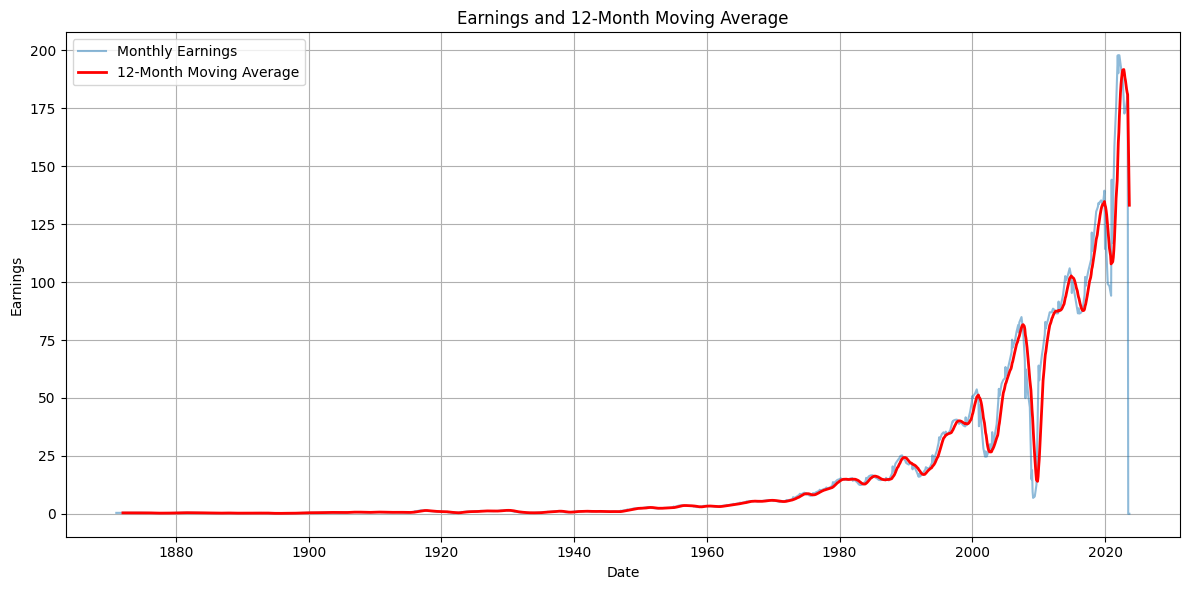

In [ ]:
df_cleaned['Earnings_MA_12'] = df_cleaned['Earnings'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Date'], df_cleaned['Earnings'], label='Monthly Earnings', alpha=0.5)
plt.plot(df_cleaned['Date'], df_cleaned['Earnings_MA_12'], label='12-Month Moving Average', color='red', linewidth=2)

plt.title('Earnings and 12-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Earnings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The first 11 rows in Earnings_MA_12 will be NaN, which Matplotlib ignores when plotting.

Plotting both raw earnings and moving average shows trend smoothing over time.

**3. SP500 normalized = (SP500 - SP500min)/(SP500max - SP500min)**

In [ ]:
sp500_min = df_cleaned['SP500'].min()
sp500_max = df_cleaned['SP500'].max()
df_cleaned['SP500_Normalized'] = (df_cleaned['SP500'] - sp500_min) / (sp500_max - sp500_min)

In [ ]:
df_cleaned

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change,Earnings_MA_12,SP500_Normalized
0,4.515000,0.26,0.40,12.415,5.335,111.325,6.41,9.86,0.00,1871-01-01,NaN,NaN,0.000382
1,4.500000,0.26,0.40,12.840,5.320,107.250,6.20,9.53,0.00,1871-02-01,NaN,NaN,0.000379
2,4.610000,0.26,0.40,13.030,5.330,108.270,6.11,9.39,0.00,1871-03-01,NaN,NaN,0.000402
3,4.740000,0.26,0.40,12.560,5.330,115.540,6.34,9.75,0.00,1871-04-01,NaN,NaN,0.000430
4,4.860000,0.26,0.40,12.270,5.330,121.220,6.48,9.98,0.00,1871-05-01,NaN,NaN,0.000456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,4146.173182,68.54,179.17,304.130,3.570,4173.450,68.99,180.35,31.14,2023-05-01,4.047212,181.906667,0.886859
1677,4345.372857,68.71,181.17,305.110,3.750,4359.880,68.94,181.77,32.41,2023-06-01,2.969863,180.825556,0.929496
1678,4508.075500,0.00,0.00,305.690,3.900,4514.510,0.00,0.00,33.38,2023-07-01,3.176050,164.803889,0.964320
1679,4457.358696,0.00,0.00,305.980,4.170,4459.480,0.00,0.00,32.91,2023-08-01,3.312287,148.921944,0.953465


In [ ]:
top_10_sp500 = df_cleaned.sort_values(by='SP500', ascending=False).head(10)
print("Top 10 Dates with Highest S&P 500 Prices:")
print(top_10_sp500[['Date', 'SP500', 'SP500_Normalized']])

Top 10 Dates with Highest S&P 500 Prices:
           Date        SP500  SP500_Normalized
1660 2021-12-01  4674.772727          1.000000
1659 2021-11-01  4667.386667          0.998419
1680 2023-09-01  4515.770000          0.965967
1678 2023-07-01  4508.075500          0.964320
1679 2023-08-01  4457.358696          0.953465
1657 2021-08-01  4454.206364          0.952790
1658 2021-09-01  4445.543333          0.950936
1662 2022-02-01  4435.980526          0.948889
1664 2022-04-01  4391.296000          0.939325
1663 2022-03-01  4391.265217          0.939318


The top 10 highest values of stocks were seen on the above 10 dates

### **Task 3: Data Visualization**

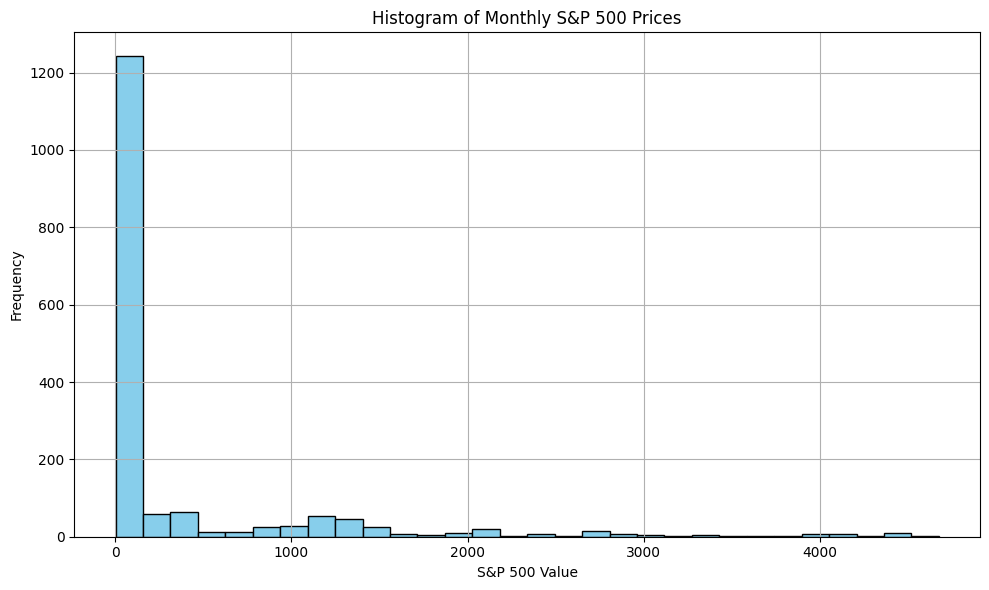

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['SP500'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Monthly S&P 500 Prices')
plt.xlabel('S&P 500 Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

The S&P 500 has increased significantly over time, but those higher values are less frequent.

Data is not normally distributed so any statistical modeling should avoid normality assumptions.

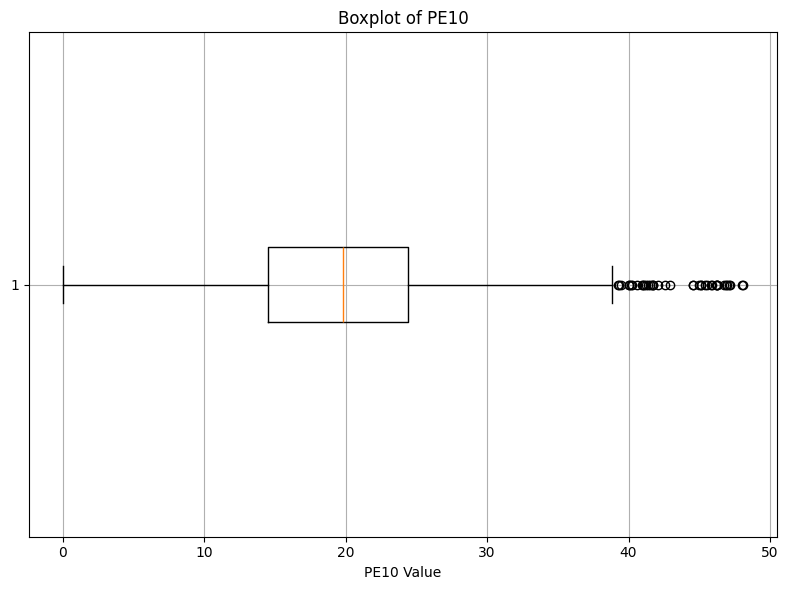

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_cleaned['PE10'].dropna(), vert=False)
plt.title('Boxplot of PE10')
plt.xlabel('PE10 Value')
plt.grid(True)
plt.tight_layout()
plt.show()

Indicates that the central tendency for the market valuation is around 20.
The box spans from about 15 to 25, representing the middle 50% of the PE10 values.
Suggests that under normal market conditions, the S&P 500 traded within this valuation range
Many dots on the right represent outliers - unusually high PE10 values.

These reflect periods of very high valuation

Outliers suggest that there were months or years where the market was significantly more expensive than average.
Longer whisker and numerous outliers on the right side indicate a right-skewed distribution.

The market tends to experience more frequent moderate valuations, with occasional high PE ratios.
The market typically trades with a PE10 ratio between 15 and 25, but can experience spikes well above that, often during speculative bubbles or loose monetary periods.


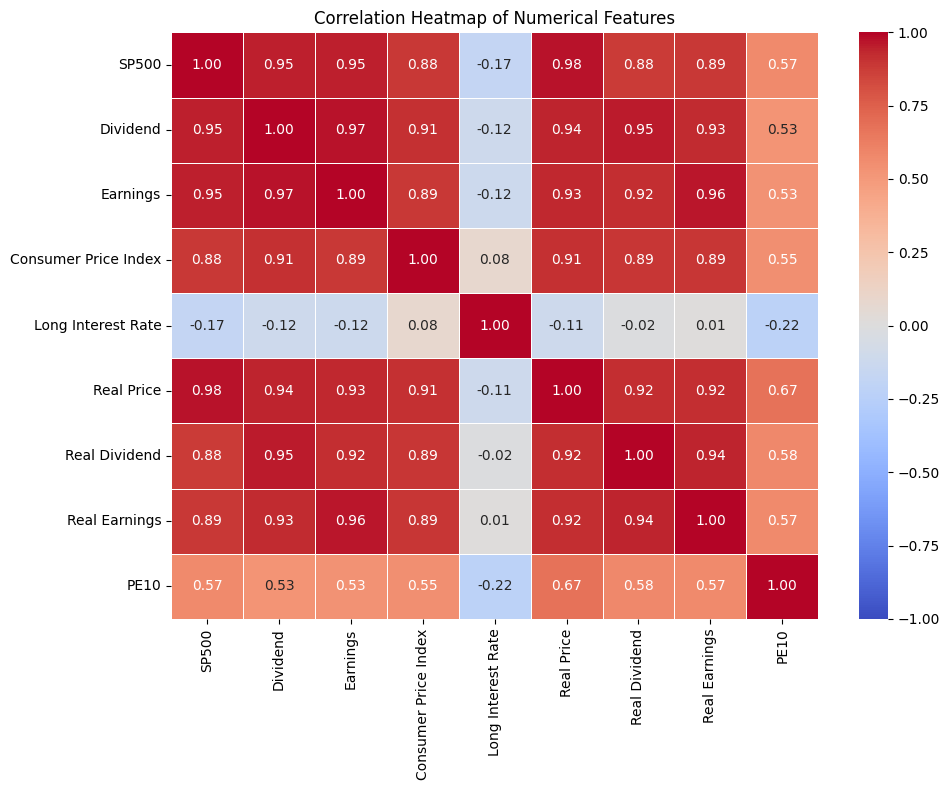

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = df_cleaned.select_dtypes(include='number').drop(columns=['CPI_YoY_Change', 'Earnings_MA_12', 'SP500_Normalized'])

# Compute correlation matrix
corr_matrix = numerical_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()



Most of these variables move together over time (highly correlated) because they're all derived from the same underlying data - SP500 index and company fundamentals.


* **SP500 and Dividend** is highly correlated because as the stock value goes up the share value you hold will also go up.
* **SP500, Real Price, Dividend, Earnings, Real Dividend, Real Earnings**: All track corporate performance. If companies grow and profits rise, prices, dividends, and earnings all rise together
* **CPI, it is in general terms called cost of living**, Inflation pushes up nominal values (Dividends, Earnings, Price), so it's also strongly correlated with them. Higher the inflation, higher the stock price does not necessarily mean the same increase in percentage of earning.
* **Long Interest Rate**: This one is negatively correlated with stocks (-0.17). High interest rates generally hurt stock valuations (makes bonds more attractive vs. stocks)
* PE10 (price to earnings ratio over avg 10 years): It's not as highly correlated because it's a ratio. It compares prices to earnings. If both move together, the ratio doesn't change much, so correlations with other variables are weaker







# **Part 2: Machine Learning**

In [ ]:
df_cleaned

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change,Earnings_MA_12,SP500_Normalized
0,4.515000,0.26,0.40,12.415,5.335,111.325,6.41,9.86,0.00,1871-01-01,NaN,NaN,0.000382
1,4.500000,0.26,0.40,12.840,5.320,107.250,6.20,9.53,0.00,1871-02-01,NaN,NaN,0.000379
2,4.610000,0.26,0.40,13.030,5.330,108.270,6.11,9.39,0.00,1871-03-01,NaN,NaN,0.000402
3,4.740000,0.26,0.40,12.560,5.330,115.540,6.34,9.75,0.00,1871-04-01,NaN,NaN,0.000430
4,4.860000,0.26,0.40,12.270,5.330,121.220,6.48,9.98,0.00,1871-05-01,NaN,NaN,0.000456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,4146.173182,68.54,179.17,304.130,3.570,4173.450,68.99,180.35,31.14,2023-05-01,4.047212,181.906667,0.886859
1677,4345.372857,68.71,181.17,305.110,3.750,4359.880,68.94,181.77,32.41,2023-06-01,2.969863,180.825556,0.929496
1678,4508.075500,0.00,0.00,305.690,3.900,4514.510,0.00,0.00,33.38,2023-07-01,3.176050,164.803889,0.964320
1679,4457.358696,0.00,0.00,305.980,4.170,4459.480,0.00,0.00,32.91,2023-08-01,3.312287,148.921944,0.953465


In [ ]:
numeric_features = ['SP500', 'Dividend', 'Earnings', 'Consumer Price Index',
            'Long Interest Rate', 'Real Price', 'Real Dividend',
            'Real Earnings', 'PE10']

X = df_cleaned[numeric_features]

In [ ]:
# normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

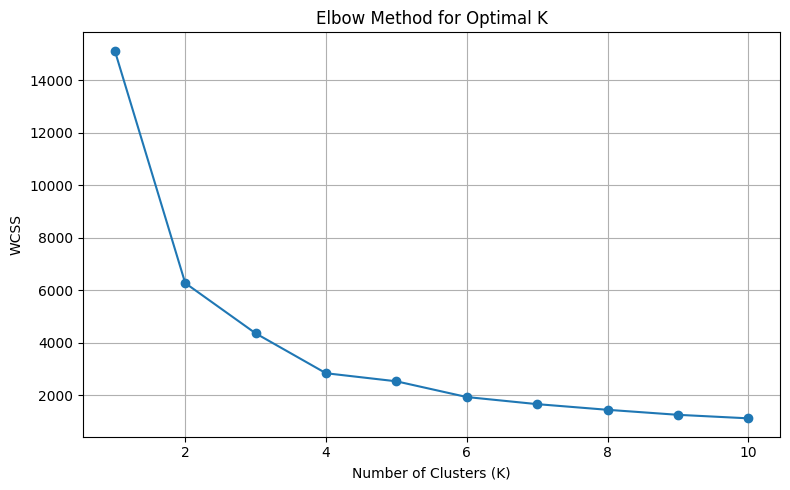

In [ ]:
# calculating within cluster sum of squares
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# finding elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Best K = 3**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

X['Cluster'] = clusters

/tmp/ipython-input-2152225487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = clusters


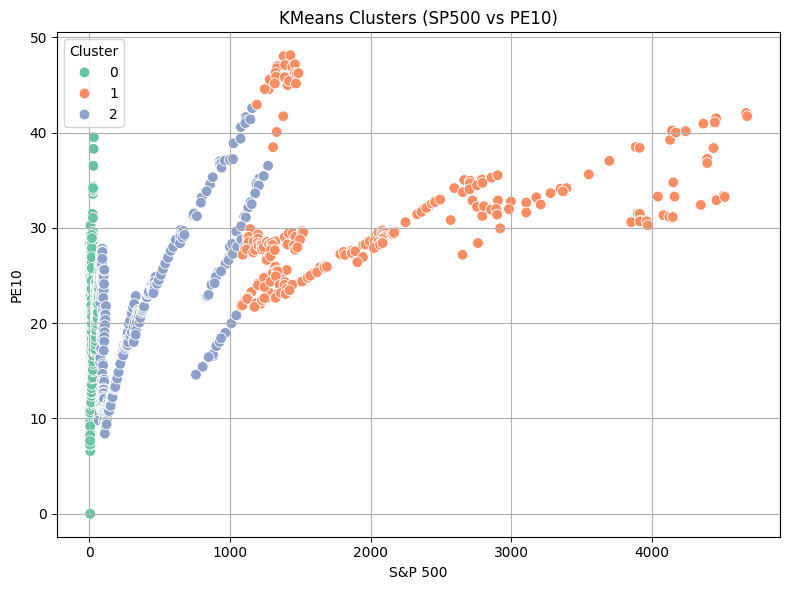

In [ ]:


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X,
    x='SP500',
    y='PE10',
    hue='Cluster',
    palette='Set2',
    s=60
)
plt.title('KMeans Clusters (SP500 vs PE10)')
plt.xlabel('S&P 500')
plt.ylabel('PE10')
plt.grid(True)
plt.tight_layout()
plt.show()


The data is split into 3 regimes of how the market was valued

Cluster 0 (green): Very early/low SP500 values with low PE10, early historical periods when both stock prices and valuations were small

Cluster 2 (blue): Mid-range SP500 and PE10, transitional periods with steady growth but valuations varied.

Cluster 1 (orange): Modern times, high SP500 values and higher PE10, recent decades when the stock market is much larger, and valuations (PE ratio) often higher.

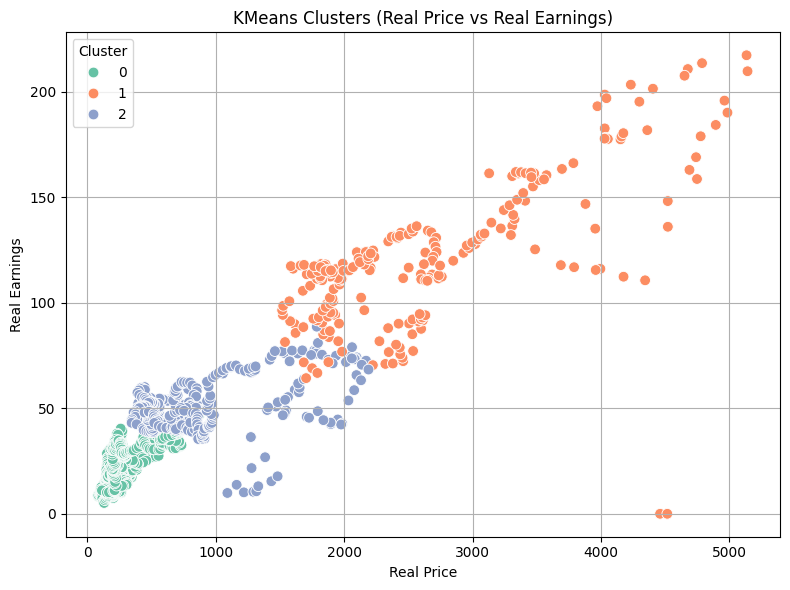

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X,
    x='Real Price',
    y='Real Earnings',
    hue='Cluster',
    palette='Set2',
    s=60
)
plt.title('KMeans Clusters (Real Price vs Real Earnings)')
plt.xlabel('Real Price')
plt.ylabel('Real Earnings')
plt.grid(True)
plt.tight_layout()
plt.show()

Cluster 0 (green): Early period - both stock prices and earnings were low in absolute terms.

Cluster 2 (blue): Mid period - moderate prices and earnings, a transition zone.

Cluster 1 (orange): Modern period - very high real prices and earnings, representing today's economy with huge corporations and high stock valuations.

## **S&P Price Prediction**

### 1. Linear Regression

In [ ]:
feature_cols = ['Dividend', 'Earnings', 'Consumer Price Index',
                'Long Interest Rate', 'Real Price', 'Real Dividend',
                'Real Earnings', 'PE10']

df_ml = df_cleaned[feature_cols + ['SP500']].dropna()

X = df_ml[feature_cols]
y = df_ml['SP500']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression - MSE: {mse:.2f}, R²: {r2:.2f}")


Linear Regression - MSE: 4701.61, R²: 0.99


model is explaining 99% of the variance in the target, with loss of 4701.61 from true y values

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest - MSE: 473.81, R²: 1.00


MSE = 473.81 -> The average squared prediction error is small. Model is accurate on the dataset it was evaluated on

R² = 1.00 -> The model explains 100% of the variance in SP500.

But R² = 1.00 is too perfect, and signals possible overfitting or data leakage

### **Consumer Price Index Trend Classification**

In [ ]:
df_cleaned.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change,Earnings_MA_12,SP500_Normalized
0,4.515,0.26,0.4,12.415,5.335,111.325,6.41,9.86,0.0,1871-01-01,NaN,NaN,0.000382
1,4.500,0.26,0.4,12.840,5.320,107.250,6.20,9.53,0.0,1871-02-01,NaN,NaN,0.000379
2,4.610,0.26,0.4,13.030,5.330,108.270,6.11,9.39,0.0,1871-03-01,NaN,NaN,0.000402
3,4.740,0.26,0.4,12.560,5.330,115.540,6.34,9.75,0.0,1871-04-01,NaN,NaN,0.000430
4,4.860,0.26,0.4,12.270,5.330,121.220,6.48,9.98,0.0,1871-05-01,NaN,NaN,0.000456


In [ ]:
# Sorting data
df_sorted = df_cleaned.sort_values('Date')

# target: if next month's CPI is higher, else 0
df_sorted['CPI_Next_Month'] = df_sorted['Consumer Price Index'].shift(-1)
df_sorted['CPI_Trend'] = (df_sorted['CPI_Next_Month'] > df_sorted['Consumer Price Index']).astype(int)
df_class = df_sorted.dropna(subset=['CPI_Next_Month'])

In [ ]:
df_class.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change,Earnings_MA_12,SP500_Normalized,CPI_Next_Month,CPI_Trend
0,4.515,0.26,0.4,12.415,5.335,111.325,6.41,9.86,0.0,1871-01-01,NaN,NaN,0.000382,12.84,1
1,4.500,0.26,0.4,12.840,5.320,107.250,6.20,9.53,0.0,1871-02-01,NaN,NaN,0.000379,13.03,1
2,4.610,0.26,0.4,13.030,5.330,108.270,6.11,9.39,0.0,1871-03-01,NaN,NaN,0.000402,12.56,0
3,4.740,0.26,0.4,12.560,5.330,115.540,6.34,9.75,0.0,1871-04-01,NaN,NaN,0.000430,12.27,0
4,4.860,0.26,0.4,12.270,5.330,121.220,6.48,9.98,0.0,1871-05-01,NaN,NaN,0.000456,12.08,0


### **Logistic Regression**

In [ ]:
# Drop CPI_Next_Month (future) and newly added features
features = df_class.select_dtypes(include='number').drop(
    columns=['CPI_Next_Month', 'CPI_Trend', 'CPI_YoY_Change', 'Earnings_MA_12', 'SP500_Normalized'],
    errors='ignore'
)

target = df_class['CPI_Trend']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

In [ ]:
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

# Predict
y_pred = logit_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6696428571428571

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.68      0.65       152
           1       0.72      0.66      0.69       184

    accuracy                           0.67       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.67      0.67      0.67       336


Confusion Matrix:
 [[104  48]
 [ 63 121]]


For CPI trend analysis, classification accuracy is 66.9%

From the confusion matrix:
*   (True Positives) = 121 Correctly predicted CPI will go up
*   (True Negatives) = 104 Correctly predicted CPI will not go up
*   (False Positives) = 48 Predicted up, but CPI didn't go up
*   (False Negatives) = 63 Predicted not up, but CPI actually went up



### **Convert Date to Ordinal**

In [ ]:
df_time = df_cleaned.copy()
df_time['Date'] = pd.to_datetime(df_time['Date'])

# Create ordinal date: year * 12 + month
df_time['Date_Ordinal'] = df_time['Date'].dt.year * 12 + df_time['Date'].dt.month

In [ ]:
df_time.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change,Earnings_MA_12,SP500_Normalized,Date_Ordinal
0,4.515,0.26,0.4,12.415,5.335,111.325,6.41,9.86,0.0,1871-01-01,NaN,NaN,0.000382,22453
1,4.500,0.26,0.4,12.840,5.320,107.250,6.20,9.53,0.0,1871-02-01,NaN,NaN,0.000379,22454
2,4.610,0.26,0.4,13.030,5.330,108.270,6.11,9.39,0.0,1871-03-01,NaN,NaN,0.000402,22455
3,4.740,0.26,0.4,12.560,5.330,115.540,6.34,9.75,0.0,1871-04-01,NaN,NaN,0.000430,22456
4,4.860,0.26,0.4,12.270,5.330,121.220,6.48,9.98,0.0,1871-05-01,NaN,NaN,0.000456,22457


In [ ]:
# CPI trend target
df_time['CPI_Next_Month'] = df_time['Consumer Price Index'].shift(-1)
df_time['CPI_Trend'] = (df_time['CPI_Next_Month'] > df_time['Consumer Price Index']).astype(int)

# Drop last row (no label)
df_time = df_time.dropna(subset=['CPI_Next_Month'])
df_time.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Date,CPI_YoY_Change,Earnings_MA_12,SP500_Normalized,Date_Ordinal,CPI_Next_Month,CPI_Trend
0,4.515,0.26,0.4,12.415,5.335,111.325,6.41,9.86,0.0,1871-01-01,NaN,NaN,0.000382,22453,12.84,1
1,4.500,0.26,0.4,12.840,5.320,107.250,6.20,9.53,0.0,1871-02-01,NaN,NaN,0.000379,22454,13.03,1
2,4.610,0.26,0.4,13.030,5.330,108.270,6.11,9.39,0.0,1871-03-01,NaN,NaN,0.000402,22455,12.56,0
3,4.740,0.26,0.4,12.560,5.330,115.540,6.34,9.75,0.0,1871-04-01,NaN,NaN,0.000430,22456,12.27,0
4,4.860,0.26,0.4,12.270,5.330,121.220,6.48,9.98,0.0,1871-05-01,NaN,NaN,0.000456,22457,12.08,0


### **SVM**

In [ ]:
# features (including Date_Ordinal)
feature_cols = df_time.select_dtypes(include='number').drop(
    columns=['CPI_Next_Month', 'CPI_Trend', 'CPI_YoY_Change', 'Earnings_MA_12', 'SP500_Normalized'],
    errors='ignore'
).columns.tolist()

X = df_time[feature_cols]

# SVM is sensitive to feature magnitude so scaling it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = df_time['CPI_Trend']

In [ ]:
feature_cols

['SP500',
 'Dividend',
 'Earnings',
 'Consumer Price Index',
 'Long Interest Rate',
 'Real Price',
 'Real Dividend',
 'Real Earnings',
 'PE10',
 'Date_Ordinal']

In [ ]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM analysis:\n", classification_report(y_test, y_pred_svm))


SVM analysis:
               precision    recall  f1-score   support

           0       0.60      0.79      0.68       152
           1       0.77      0.57      0.65       184

    accuracy                           0.67       336
   macro avg       0.68      0.68      0.67       336
weighted avg       0.69      0.67      0.67       336



67% of total predictions were correct.

Class 0: High recall (0.79), it means model is good at catching when CPI doesn't rise

Class 1: Higher precision (0.77) - when it predicts CPI rise, it's right 77% of the time

F1-scores ~ 0.65-0.68
Indicates good balance between precision and recall for both classes

### **KNN**

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("KNN analysis:\n", classification_report(y_test, y_pred_knn))


KNN analysis:
               precision    recall  f1-score   support

           0       0.61      0.59      0.60       152
           1       0.67      0.69      0.68       184

    accuracy                           0.64       336
   macro avg       0.64      0.64      0.64       336
weighted avg       0.64      0.64      0.64       336



KNN correctly classifies 64% of cases. Decent performance for a simple model. Model is fairly reliable in predicting CPI increases.

### **Neural Network**

In [ ]:
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1700, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)

print("Neural Network analysis:\n", classification_report(y_test, y_pred_nn))


Neural Network analysis:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64       152
           1       0.70      0.68      0.69       184

    accuracy                           0.67       336
   macro avg       0.66      0.67      0.66       336
weighted avg       0.67      0.67      0.67       336



Neural Net is on par with Logistic Regression and SVM in this case.

Performance gains are marginal because:

Dataset is not large or complex enough

Neural nets are harder to tune, especially on small datasets

It's a good choice, but Logistic Regression or SVM is better for interpretability and simplicity.